In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas
  
od.download(
    "https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

100%|██████████| 1.76G/1.76G [00:12<00:00, 152MB/s]


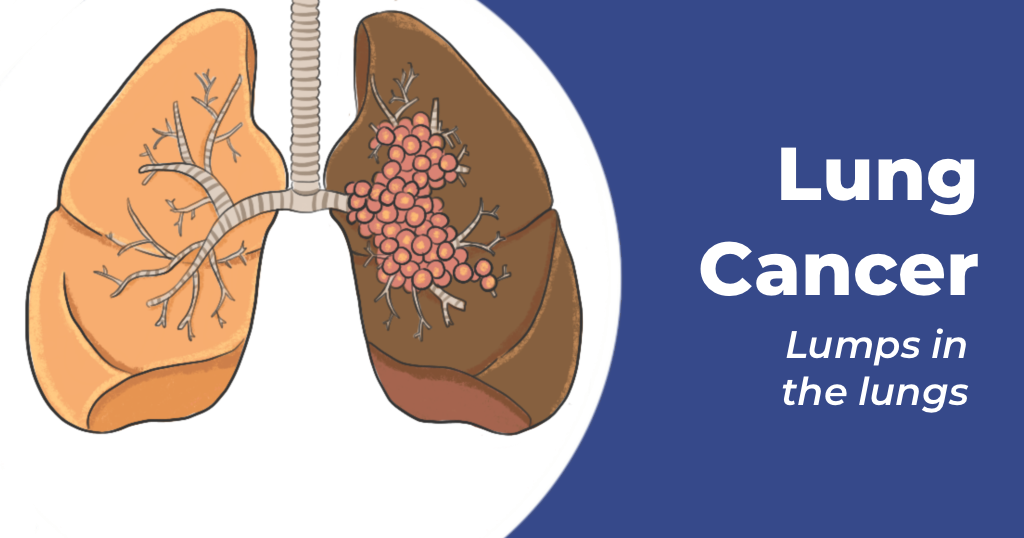

## About the data

folder lung_image_sets contains three secondary subfolders: lung_aca subfolder with 5000 images of lung adenocarcinomas, lung_scc subfolder with 5000 images of lung squamous cell carcinomas, and lung_n subfolder with 5000 images of benign lung tissues.

# Importing libraries

In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts 
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## Data loading and exploring 

In [ ]:
lung_dir = "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
lungs = os.listdir(lung_dir)

In [ ]:
lungs

['lung_scc', 'lung_n', 'lung_aca']

In [ ]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for lung in lungs:
    nums_train[lung] = len(os.listdir(lung_dir + '/' + lung))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
lung_scc,5000
lung_n,5000
lung_aca,5000


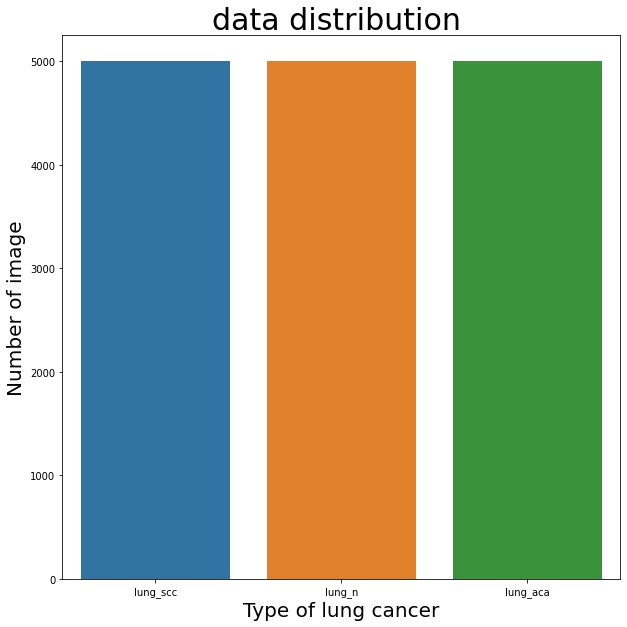

In [ ]:
plt.figure(figsize=(10,10))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of lung cancer',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)


# Show some example for lung cancer

In [ ]:
# Function to show image
train = ImageFolder(lung_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

## Lung_aca

Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)


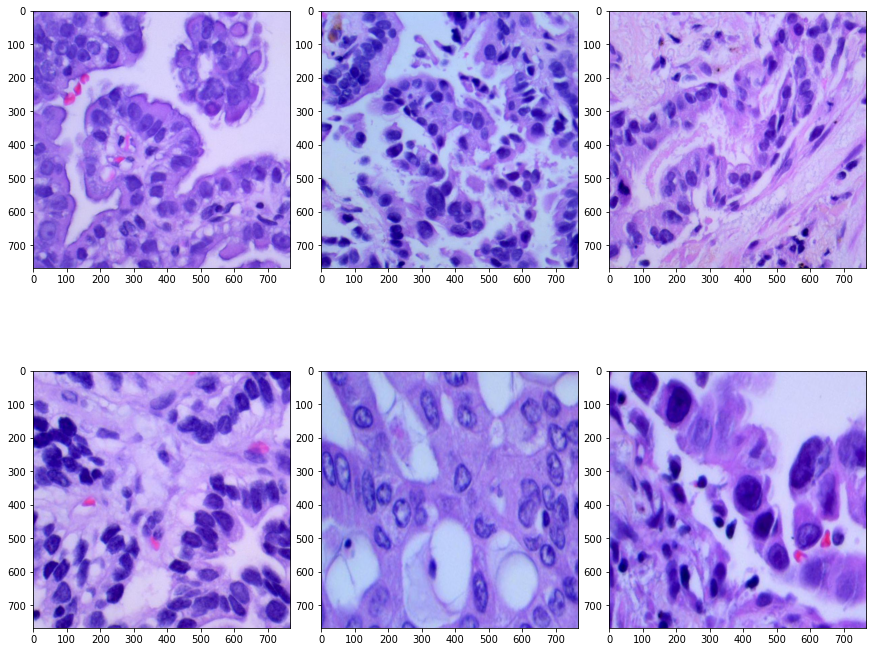

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[1]))
axs[0,1].imshow(show_image(*train[1100]))
axs[1, 0].imshow(show_image(*train[2010]))
axs[1,1].imshow(show_image(*train[3500]))
axs[0,2].imshow(show_image(*train[4120]))
axs[1,2].imshow(show_image(*train[4860]))

## Lung_n

Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)


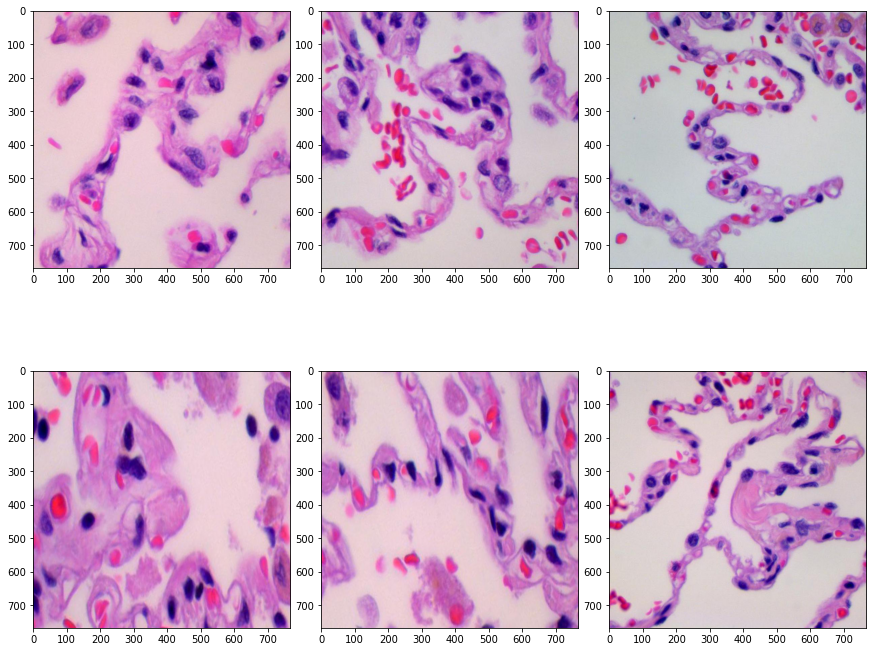

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[5010]))
axs[0,1].imshow(show_image(*train[6050]))
axs[1, 0].imshow(show_image(*train[7000]))
axs[1,1].imshow(show_image(*train[7500]))
axs[0,2].imshow(show_image(*train[8000]))
axs[1,2].imshow(show_image(*train[8620]))

## Lung_scc

Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)


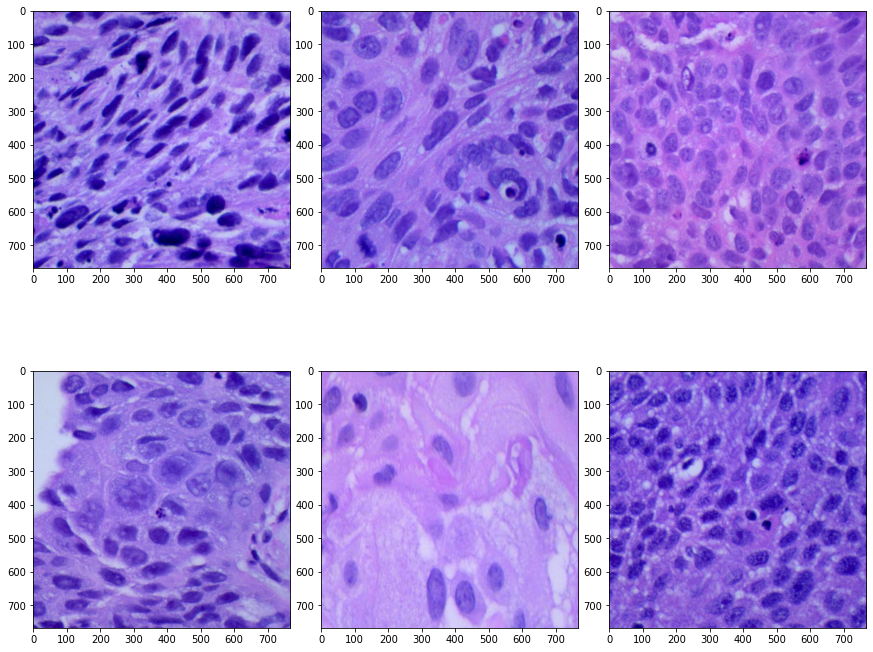

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[11001]))
axs[0,1].imshow(show_image(*train[12000]))
axs[1, 0].imshow(show_image(*train[13050]))
axs[1,1].imshow(show_image(*train[14000]))
axs[0,2].imshow(show_image(*train[14200]))
axs[1,2].imshow(show_image(*train[14800]))

# Modeling

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(lung_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=True)

val_data = valid_gen.flow_from_directory(lung_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=False)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [ ]:
import numpy
unique, counts = numpy.unique(val_data.classes, return_counts=True)

dict(zip(unique, counts))

{0: 1000, 1: 1000, 2: 1000}

## model_1

In [ ]:
model_1 = keras.models.Sequential()

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.15))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(128, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dense(3, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

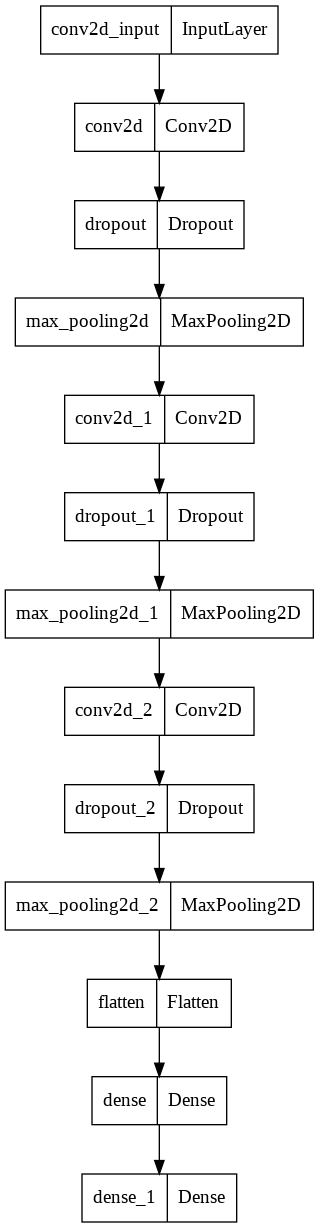

In [ ]:
keras.utils.plot_model(
    model_1,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_1.fit(train_data,
          validation_data=val_data,
          epochs = 10)

Epoch 1/10
188/188 [==============================] - 238s 1s/step - loss: 0.7002 - accuracy: 0.8008 - val_loss: 0.2788 - val_accuracy: 0.8847
Epoch 2/10
188/188 [==============================] - 220s 1s/step - loss: 0.2145 - accuracy: 0.9143 - val_loss: 0.2155 - val_accuracy: 0.9113
Epoch 3/10
188/188 [==============================] - 220s 1s/step - loss: 0.1842 - accuracy: 0.9269 - val_loss: 0.2783 - val_accuracy: 0.8677
Epoch 4/10
188/188 [==============================] - 220s 1s/step - loss: 0.1520 - accuracy: 0.9388 - val_loss: 0.1459 - val_accuracy: 0.9480
Epoch 5/10
188/188 [==============================] - 221s 1s/step - loss: 0.1489 - accuracy: 0.9408 - val_loss: 0.2736 - val_accuracy: 0.8880
Epoch 6/10
188/188 [==============================] - 220s 1s/step - loss: 0.1248 - accuracy: 0.9515 - val_loss: 0.2231 - val_accuracy: 0.8977
Epoch 7/10
188/188 [==============================] - 221s 1s/step - loss: 0.1122 - accuracy: 0.9557 - val_loss: 0.2286 - val_accuracy: 0.8943

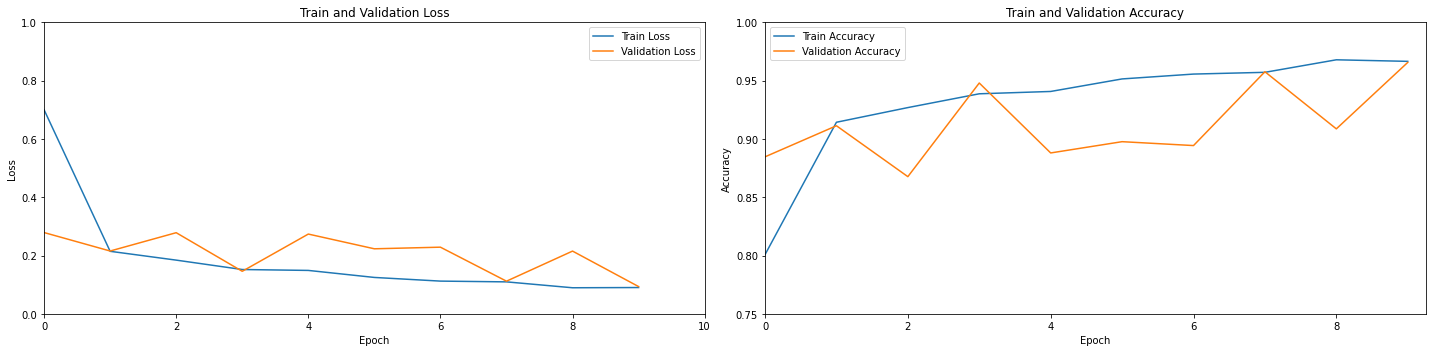

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_1.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

47/47 [==============================] - 23s 485ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1000
           1       1.00      1.00      1.00      1000
           2       0.93      0.97      0.95      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



## Model_2

In [ ]:
model_2 = keras.models.Sequential()

model_2.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_2.add(keras.layers.Dropout(0.1))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_2.add(keras.layers.Dropout(0.2))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(128, activation='relu'))
model_2.add(keras.layers.Dense(3, activation='softmax'))

model_2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_3 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

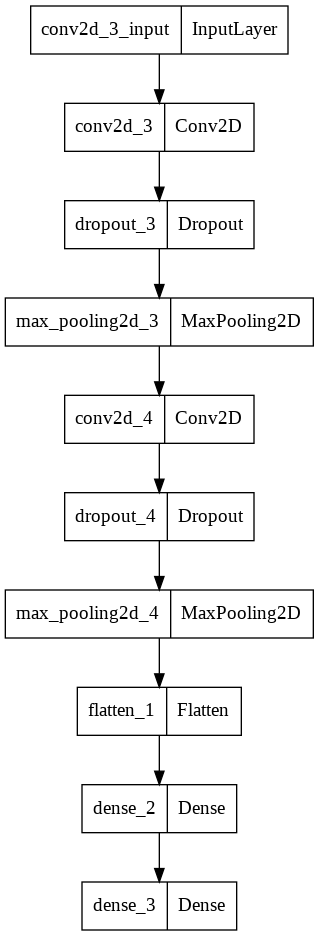

In [ ]:
keras.utils.plot_model(
    model_2,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_2.fit(train_data,
          validation_data=val_data,
          epochs = 10)

Epoch 1/10
188/188 [==============================] - 220s 1s/step - loss: 0.6717 - accuracy: 0.8143 - val_loss: 0.2501 - val_accuracy: 0.9090
Epoch 2/10
188/188 [==============================] - 217s 1s/step - loss: 0.2417 - accuracy: 0.9037 - val_loss: 0.2517 - val_accuracy: 0.9090
Epoch 3/10
188/188 [==============================] - 218s 1s/step - loss: 0.2110 - accuracy: 0.9171 - val_loss: 0.1972 - val_accuracy: 0.9273
Epoch 4/10
188/188 [==============================] - 217s 1s/step - loss: 0.1984 - accuracy: 0.9196 - val_loss: 0.1830 - val_accuracy: 0.9237
Epoch 5/10
188/188 [==============================] - 218s 1s/step - loss: 0.1697 - accuracy: 0.9317 - val_loss: 0.1592 - val_accuracy: 0.9350
Epoch 6/10
188/188 [==============================] - 218s 1s/step - loss: 0.1473 - accuracy: 0.9417 - val_loss: 0.1755 - val_accuracy: 0.9260
Epoch 7/10
188/188 [==============================] - 220s 1s/step - loss: 0.1364 - accuracy: 0.9451 - val_loss: 0.1728 - val_accuracy: 0.9353

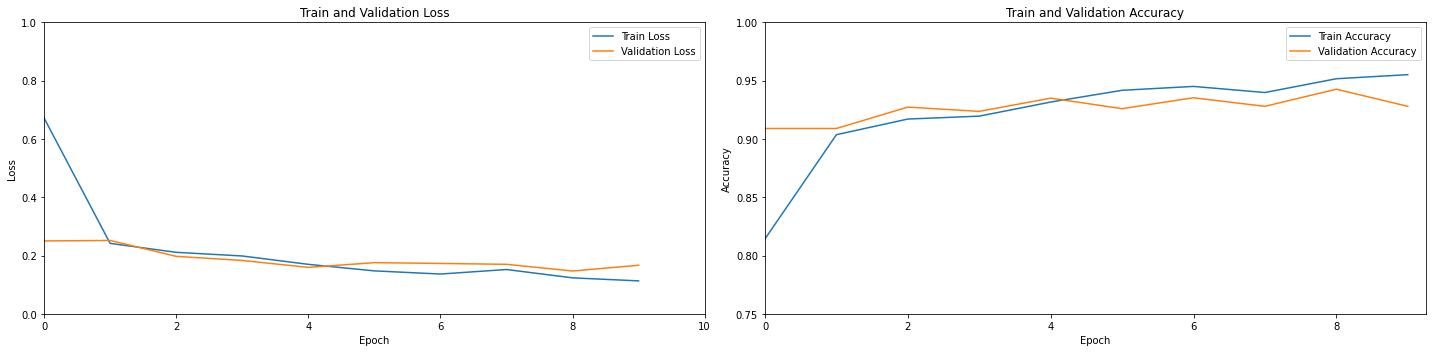

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_2.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

47/47 [==============================] - 23s 478ms/step
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1000
           1       1.00      1.00      1.00      1000
           2       0.98      0.81      0.88      1000

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.93      0.93      3000



## Model_3

In [ ]:
model_3 = keras.models.Sequential()

model_3.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model_3.add(keras.layers.MaxPooling2D())

model_3.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_3.add(keras.layers.MaxPooling2D())

model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(128, activation='relu'))
model_3.add(keras.layers.Dense(3, activation='softmax'))

model_3.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

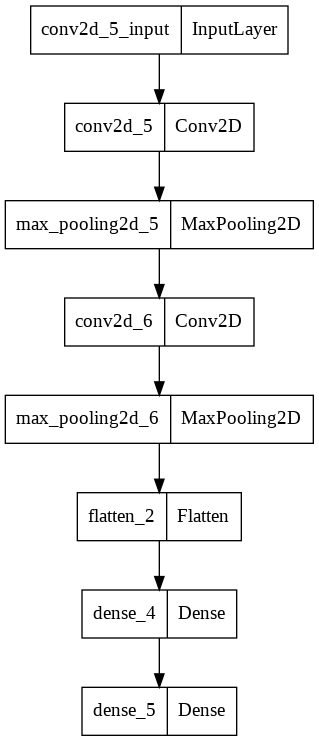

In [ ]:
keras.utils.plot_model(
    model_3,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_3.fit(train_data,
          validation_data=val_data,
          epochs = 15)

Epoch 1/15
188/188 [==============================] - 217s 1s/step - loss: 0.6290 - accuracy: 0.7845 - val_loss: 0.3442 - val_accuracy: 0.8513
Epoch 2/15
188/188 [==============================] - 214s 1s/step - loss: 0.2842 - accuracy: 0.8792 - val_loss: 0.2331 - val_accuracy: 0.9017
Epoch 3/15
188/188 [==============================] - 214s 1s/step - loss: 0.2312 - accuracy: 0.9062 - val_loss: 0.2209 - val_accuracy: 0.9067
Epoch 4/15
188/188 [==============================] - 215s 1s/step - loss: 0.1949 - accuracy: 0.9213 - val_loss: 0.2497 - val_accuracy: 0.8920
Epoch 5/15
188/188 [==============================] - 216s 1s/step - loss: 0.1578 - accuracy: 0.9379 - val_loss: 0.1624 - val_accuracy: 0.9380
Epoch 6/15
188/188 [==============================] - 216s 1s/step - loss: 0.1549 - accuracy: 0.9387 - val_loss: 0.1493 - val_accuracy: 0.9400
Epoch 7/15
188/188 [==============================] - 218s 1s/step - loss: 0.1322 - accuracy: 0.9488 - val_loss: 0.1443 - val_accuracy: 0.9417

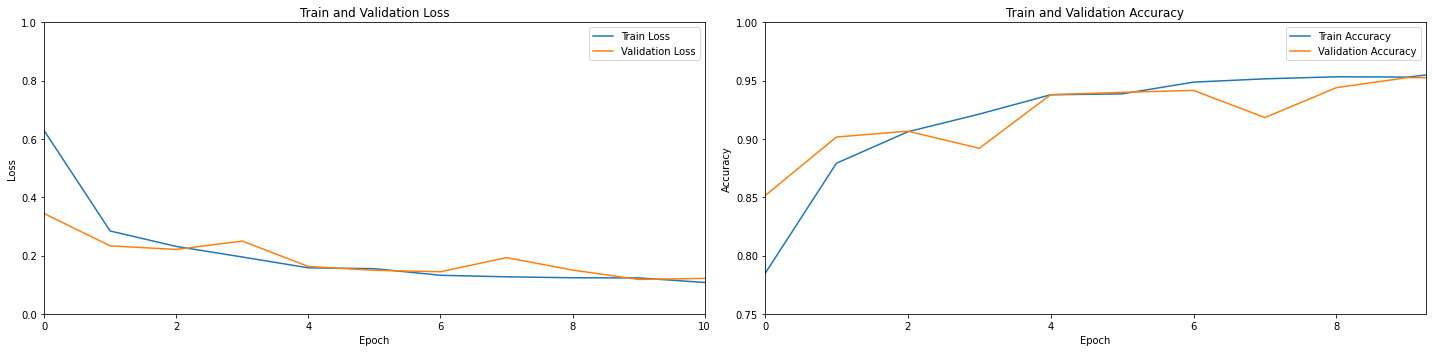

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_3.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

47/47 [==============================] - 83s 2s/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1000
           1       1.00      1.00      1.00      1000
           2       0.95      0.93      0.94      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



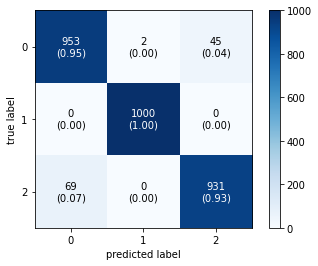

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()